In [1]:
import os
# WARNING: Execute this cell only once !
os.chdir('../')

In [2]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
import numpy as np
import torch

/Users/fermanian/.conda/envs/sigenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Plots requirements

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

sns.set_style('whitegrid')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

sns.set_palette('colorblind')

color_palette = sns.color_palette("colorblind")

In [5]:
from src.datagen import create_X, get_train_val_test, TumorGrowth
from src.models import SigLasso, GRUModel, NeuralCDE
from src.sampling import downsample
from src.utils import get_cumulative_moving_sum, fill_forward, l2_distance, mse_last_point, normalize_path
from src.train import train_gru, train_neural_cde

In [6]:
from experiments.configs import grid_n_points_Y

In [47]:
model_X = 'cubic'
model_Y = 'cde'

n_points_true = 1000

dim_X = 3
dim_Y = 1
non_linearity_Y = 'Tanh'

n_train = n_test = n_val = 50

n_points_Y = 0
n_points_X = 100

In [48]:
X_raw_train, Y_raw_train, X_raw_val, Y_raw_val, X_raw_test, Y_raw_test = get_train_val_test(
    model_X,
    model_Y, 
    n_train, 
    n_val, 
    n_test,
    n_points_true,
    dim_X=dim_X, 
    dim_Y=dim_Y,
    non_linearity_Y=non_linearity_Y
)

In [49]:
print(f'X_raw_train shape: {X_raw_train.shape}, Y_raw_train shape: {Y_raw_train.shape}')

X_raw_train shape: torch.Size([50, 1000, 3]), Y_raw_train shape: torch.Size([50, 1000, 1])


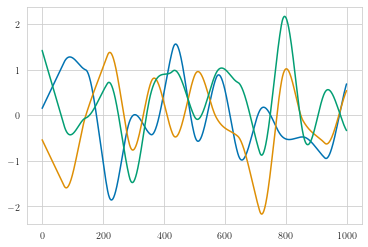

In [50]:
plt.plot(X_raw_train[:3, :, 1].T)
plt.show()

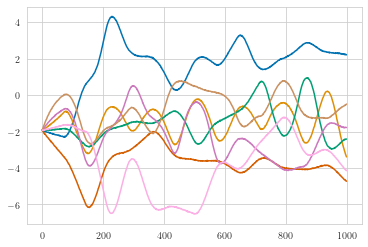

In [51]:
plt.plot(Y_raw_train[:7, :, 0].T)
plt.show()

In [52]:
X_train, grid_X_train = downsample(
        X_raw_train, n_points_X, keep_first=True, keep_last=True)
Y_train, grid_Y_train = downsample(
        Y_raw_train, n_points_Y, keep_first=False, keep_last=True,
        on_grid=grid_X_train)

X_val, grid_X_val = downsample(
        X_raw_val, n_points_X, keep_first=True, keep_last=True)
Y_val, grid_Y_val = downsample(
        Y_raw_val, n_points_Y, keep_first=False, keep_last=True,
        on_grid=grid_X_val)

In [53]:
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

X_train shape: torch.Size([50, 102, 3])
Y_train shape: torch.Size([50, 1, 1])


In [63]:
sig_order = 3

lasso_sig = SigLasso(sig_order, Y_train.shape[2], weighted=False, normalize=False)
print(X_train.shape, Y_train.shape, grid_Y_train.shape)
lasso_sig.train(X_train, Y_train, grid_Y_train)

torch.Size([50, 102, 3]) torch.Size([50, 1, 1]) torch.Size([50, 1])


/Users/fermanian/.conda/envs/sigenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [64]:
Y_train_pred = lasso_sig.predict(X_raw_train)
Y_test_pred = lasso_sig.predict(X_raw_test)

In [65]:
print(f'l2_train = ', l2_distance(Y_train_pred, Y_raw_train[:, 1:, :]))
print(f'l2_test = ',l2_distance(Y_test_pred, Y_raw_test[:, 1:, :]))

print(f'mse_last_point_train = ', mse_last_point(Y_train_pred, Y_raw_train))
print(f'mse_last_point_test = ', mse_last_point(Y_test_pred, Y_raw_test))

l2_train =  0.8603658875959286
l2_test =  0.8676125033989724
mse_last_point_train =  0.48127353353279334
mse_last_point_test =  1.6970191543453055


In [66]:
# dim_X = 3

# Weighted = True, Normalize = True, l2_train = 0.7774045227294262
# Weighted = False, Normalize = True, l2_train = 0.8393274910326501
# Weighted = False, Normalize = False, l2_train = 0.8603658875959286
# Weighted = True, Normalize = False, l2_train = 1.2505508792804314

In [ ]:
# dim_X = 2

# Weighted = True, Normalize = True, l2_train = 0.036425119134064265
# Weighted = False, Normalize = True, l2_train = 0.03379801857613828
# Weighted = False, Normalize = False, l2_train = 0.08744708024515678
# Weighted = True, Normalize = False, l2_train = 0.0967681350625942

In [29]:
sig_X, _ = lasso_sig.get_final_matrices(X_train, Y_train, grid_X_train)

In [30]:
index_order = 0
norms = []
for k in range(sig_order):
    norms.append(np.linalg.norm(sig_X[0, dim_X**k: dim_X**(k+1)]))

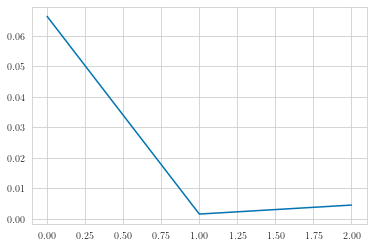

In [31]:
plt.plot(norms)

(50, 14)


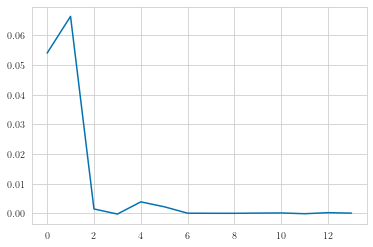

In [32]:
print(sig_X.shape)
plt.plot(sig_X[0, :])

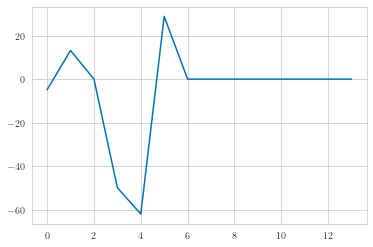

In [33]:
plt.plot(lasso_sig.reg.coef_)

In [ ]:
cde_hidden_units = 32
n_epochs = 1

cde_model = NeuralCDE(dim_X, dim_Y)

train_neural_cde(cde_model, X_sampled, Y_sampled, n_epochs, grid_Y=grid_Y)

In [ ]:
cde_model.predict_trajectory(X_train).shape

In [ ]:
gru_hidden_units = 128
n_epochs = 6

gru_model = GRUModel(dim_X, gru_hidden_units, dim_Y)

train_gru(gru_model, X_sampled, Y_sampled, n_epochs, grid_Y=grid_Y)

In [21]:
Y_pred = gru_model.predict_trajectory(X_test)
print(Y_pred.shape)

torch.Size([100, 100, 1])


In [23]:
print(gru_model.get_l2_error(X_test, Y_test))

0.03849236


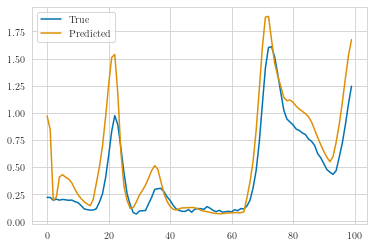

In [24]:
i = 3

plt.plot(np.arange(Y_test.shape[1]), Y_test[i, :, 0], label='True')
plt.plot(np.arange(Y_pred.shape[1]), Y_pred[i, :, 0], label='Predicted')
plt.xlabel("test"
plt.legend()
plt.show()

In [43]:
sig_order = 5

In [45]:
sigX, Yfinal = reg.get_final_matrices(X_sampled, Y_sampled, grid_Y)
print(sigX.shape, Yfinal.shape)

torch.Size([50, 62]) torch.Size([50, 3])


In [46]:
print(reg.reg.intercept_)
print(reg.reg.alpha_)

[-1.15799235  0.6031549  -0.06622822]
0.0003906939937054613


In [47]:
print(X_sampled.shape)
print(grid_X.shape)
Ypred = reg.predict(X_sampled, on_grid=grid_X[:, 1:])
print(Ypred.shape)

torch.Size([10, 100, 2])
torch.Size([10, 100])
torch.Size([10, 99, 3])


In [48]:
full_grid = torch.from_numpy(np.tile(np.arange(Y_train.shape[1]), (Y_train.shape[0], 1)))[:, 1:]
print(full_grid)

tensor([[  1,   2,   3,  ..., 497, 498, 499],
        [  1,   2,   3,  ..., 497, 498, 499],
        [  1,   2,   3,  ..., 497, 498, 499],
        ...,
        [  1,   2,   3,  ..., 497, 498, 499],
        [  1,   2,   3,  ..., 497, 498, 499],
        [  1,   2,   3,  ..., 497, 498, 499]])


In [49]:
full_grid = torch.from_numpy(np.tile(np.arange(Y_train.shape[1]), (Y_train.shape[0], 1)))
print(reg.get_l2_error(X_sampled, Y_train[:, 1:, :], full_grid[:, 1:]))

0.7680624732389101


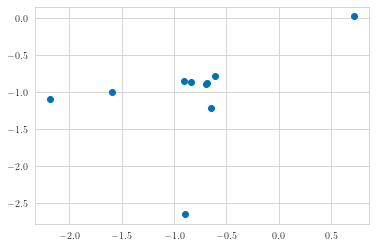

In [50]:
plt.scatter(Y_train[:, -1, 0], Ypred[:, -1, 0])

Text(0.5, 0, 'hello')

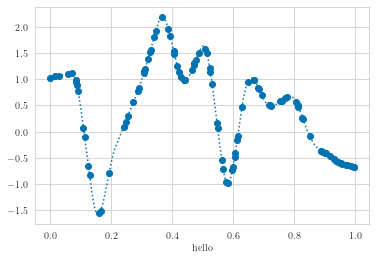

In [52]:
i = 1
plt.plot(np.arange(n_points_true) / n_points_true, X_train[i, :, 1], ':', color=color_palette[0]) 
plt.plot(grid_X[i, :] / n_points_true, X_sampled[i, :, 1], 'o', color=color_palette[0])
plt.xlabel('hello')

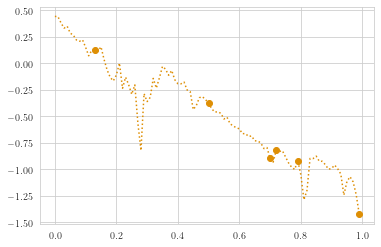

In [32]:
i = 1
plt.plot(np.arange(n_points_true) / n_points_true, Y_train[i, :, 0], ':', color=color_palette[1]) 
plt.plot(grid_Y[i, :] / n_points_true, Y_sampled[i, :, 0], 'o', color=color_palette[1])

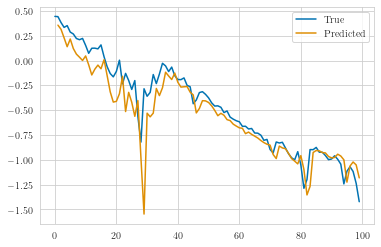

In [33]:
plt.plot(np.arange(Y_train.shape[1]), Y_train[i, :, 0], label='True')
plt.plot(grid_X[i, 1:], Ypred[i, :, 0], label='Predicted')
plt.legend()
plt.show()